<a href="https://colab.research.google.com/github/adamu96/di_time_series_forecast/blob/main/di_weather_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import and clean data

In [ ]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression
from statsmodels.tsa.deterministic import DeterministicProcess
from sklearn.feature_selection import mutual_info_regression
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [ ]:
import holidays

# import holiday data
ni_holidays = {}
ni_holidays['date'] = [date for date, name in sorted(holidays.GB(subdiv='Northern Ireland', years=[2019, 2020, 2021, 2022, 2023]).items())]
ni_holidays['holiday'] = [1 for date, name in sorted(holidays.GB(subdiv='Northern Ireland', years=[2019, 2020, 2021, 2022, 2023]).items())]
ni_holidays = pd.DataFrame(ni_holidays)
ni_holidays['date'] = pd.to_datetime(ni_holidays['date'], dayfirst=True)

In [ ]:
# import weather data
weather = pd.read_csv('/content/weather_data_historic.csv')
weather['Day'] = pd.to_datetime(weather['Day'], dayfirst=True)

# import di data
di = pd.read_csv('/content/di_data_historic.csv')
di['periodDate'] = pd.to_datetime(di['periodDate'], dayfirst=True)

# import leakage data
leak = pd.read_csv('/content/leakage_historic_daily.csv')
leak['N_DATE'] = pd.to_datetime(leak['N_DATE'], dayfirst=True)

# join tables
df = di.merge(weather, how='left', left_on='periodDate', right_on='Day')
df = df.merge(leak, how='left', left_on='Day', right_on='N_DATE')
df = df.merge(ni_holidays, how='left', left_on='Day', right_on='date')
df['holiday'] = df['holiday'].fillna(0)

# drop unnecessary columns/rows and set index
df = df.drop(columns=['periodDate', 'N_DATE', 'date', 'Unnamed: 2'])
df = df.dropna()
df = df.set_index('Day').asfreq('d')

# rename col and sort out dtypes
df = df.rename(columns={'SUM(CH.DAYLEAK)': 'leak'})

df['leak'] = df['leak'].str.replace(',','')
df['leak'] = df['leak'].astype(float)

# flow data for 06/07/2021 is missing so impute values for that row
for col in df.columns:
  df[col] = df[col].fillna(df[col].mean())


df['freeze'] = df['Minimum'].apply(lambda x: 1 if x < 1 else 0)

## Create Functions

In [ ]:
def seasonal_plot(X, y, period, freq, ax=None):
    if ax is None:
        _, ax = plt.subplots()
    palette = sns.color_palette("husl", n_colors=X[period].nunique(),)
    ax = sns.lineplot(
        x=freq,
        y=y,
        hue=period,
        data=X,
        errorbar=('ci', False),
        ax=ax,
        palette=palette,
        legend=False,
    )
    ax.set_title(f"Seasonal Plot ({period}/{freq})")
    for line, name in zip(ax.lines, X[period].unique()):
        y_ = line.get_ydata()[-1]
        ax.annotate(
            name,
            xy=(1, y_),
            xytext=(6, 0),
            color=line.get_color(),
            xycoords=ax.get_yaxis_transform(),
            textcoords="offset points",
            size=14,
            va="center",
        )
    return ax


def plot_periodogram(ts, detrend='linear', ax=None):
    from scipy.signal import periodogram
    fs = pd.Timedelta("1Y") / pd.Timedelta("1D")
    freqencies, spectrum = periodogram(
        ts,
        fs=fs,
        detrend=detrend,
        window="boxcar",
        scaling='spectrum',
    )
    if ax is None:
        _, ax = plt.subplots()
    ax.step(freqencies, spectrum, color="purple")
    ax.set_xscale("log")
    ax.set_xticks([1, 2, 4, 6, 12, 26, 52, 104])
    ax.set_xticklabels(
        [
            "Annual (1)",
            "Semiannual (2)",
            "Quarterly (4)",
            "Bimonthly (6)",
            "Monthly (12)",
            "Biweekly (26)",
            "Weekly (52)",
            "Semiweekly (104)",
        ],
        rotation=30,
    )
    ax.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))
    ax.set_ylabel("Variance")
    ax.set_title("Periodogram")
    return ax
  
def lagplot(x, y=None, lag=1, standardize=False, ax=None, **kwargs):
    from matplotlib.offsetbox import AnchoredText
    x_ = x.shift(lag)
    if standardize:
        x_ = (x_ - x_.mean()) / x_.std()
    if y is not None:
        y_ = (y - y.mean()) / y.std() if standardize else y
    else:
        y_ = x
    corr = y_.corr(x_)
    if ax is None:
        fig, ax = plt.subplots()
    scatter_kws = dict(
        alpha=0.75,
        s=3,
    )
    line_kws = dict(color='C3', )
    ax = sns.regplot(x=x_,
                     y=y_,
                     scatter_kws=scatter_kws,
                     line_kws=line_kws,
                     lowess=True,
                     ax=ax,
                     **kwargs)
    at = AnchoredText(
        f"{corr:.2f}",
        prop=dict(size="large"),
        frameon=True,
        loc="upper left",
    )
    at.patch.set_boxstyle("square, pad=0.0")
    ax.add_artist(at)
    ax.set(title=f"Lag {lag}", xlabel=x_.name, ylabel=y_.name)
    return ax


def plot_lags(x, y=None, lags=6, nrows=1, lagplot_kwargs={}, **kwargs):
    import math
    kwargs.setdefault('nrows', nrows)
    kwargs.setdefault('ncols', math.ceil(lags / nrows))
    kwargs.setdefault('figsize', (kwargs['ncols'] * 2, nrows * 2 + 0.5))
    fig, axs = plt.subplots(sharex=True, sharey=True, squeeze=False, **kwargs)
    for ax, k in zip(fig.get_axes(), range(kwargs['nrows'] * kwargs['ncols'])):
        if k + 1 <= lags:
            ax = lagplot(x, y, lag=k + 1, ax=ax, **lagplot_kwargs)
            ax.set_title(f"Lag {k + 1}", fontdict=dict(fontsize=14))
            ax.set(xlabel="", ylabel="")
        else:
            ax.axis('off')
    plt.setp(axs[-1, :], xlabel=x.name)
    plt.setp(axs[:, 0], ylabel=y.name if y is not None else x.name)
    fig.tight_layout(w_pad=0.1, h_pad=0.1)
    return fig

def make_lags(ts, lags):
    return pd.concat(
        {
            f'y_lag_{i}': ts.shift(i)
            for i in range(1, lags + 1)
        },
        axis=1)

def make_mi_scores(X, y, discrete_features=None):
    mi_scores = mutual_info_regression(X, y)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores


def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")


## Exploratory Analysis

In [ ]:
df.describe()

,Flow (Ml/d),30cm,Maximum,Minimum,Average(Dry Bulb),100cm,leak,holiday,freeze
count,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000
mean,608.056068,11.716735,14.563649,6.937174,10.243896,11.656379,136699.737997,0.037037,0.113699
std,26.151550,4.071436,5.330957,4.761425,5.105342,3.092638,9529.492812,0.188853,0.317663
min,533.041840,3.900000,-1.500000,-7.100000,-6.900000,6.800000,122890.110000,0.000000,0.000000
25%,592.087548,7.900000,10.700000,3.600000,6.425000,8.600000,131594.070000,0.000000,0.000000
50%,604.760155,11.450000,14.500000,7.100000,10.500000,11.750000,134402.530000,0.000000,0.000000
75%,619.114110,15.675000,18.500000,10.700000,14.300000,14.600000,137652.217500,0.000000,0.000000
max,743.490740,19.200000,31.300000,17.800000,24.100000,16.600000,183103.370000,1.000000,1.000000


Text(0.5, 1.0, 'Correlation Heatmap of Weather Metrics to DI')

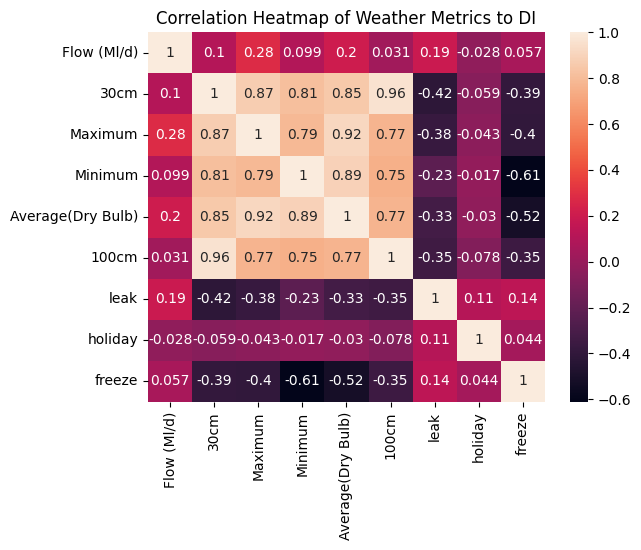

In [ ]:
sns.heatmap(data=df.corr(), annot=True)
plt.title('Correlation Heatmap of Weather Metrics to DI')

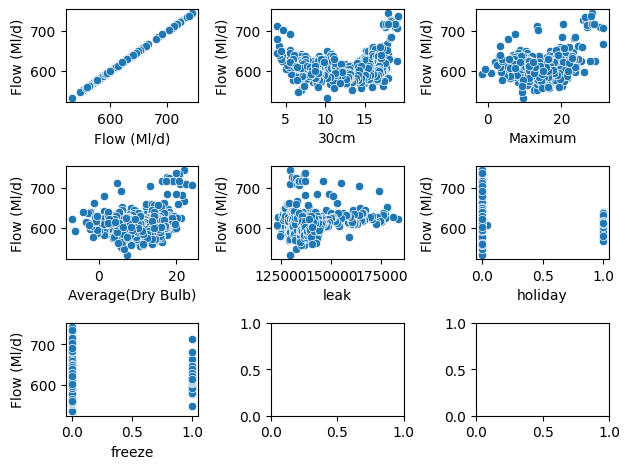

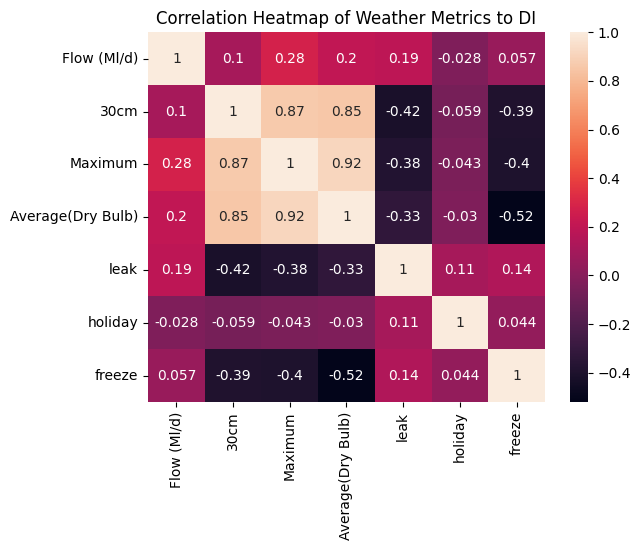

In [ ]:
fig, ax = plt.subplots(ncols=3, nrows=3)

X = df.copy()

X.pop('100cm') # dropping this featured to reduce collinearity - benefitted error
X.pop('Minimum') # dropping this featured to reduce collinearity - benefitted error

for ax, feature in zip(ax.flatten(), X.columns):
  sns.scatterplot(x=X[feature], y=X['Flow (Ml/d)'], ax=ax)
fig.tight_layout()
plt.show()

sns.heatmap(data=X.corr(), annot=True)
plt.title('Correlation Heatmap of Weather Metrics to DI')
plt.show()

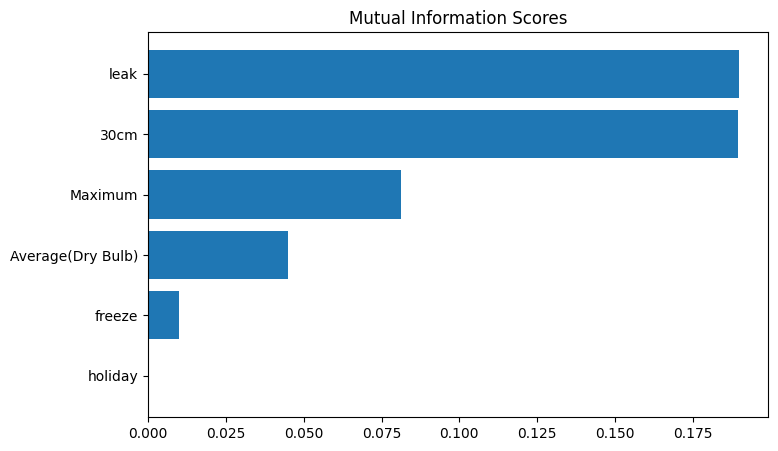

In [ ]:
y = X.pop('Flow (Ml/d)')
X_xgb = X
mi_scores = make_mi_scores(X, y)

plt.figure(dpi=100, figsize=(8, 5))
plot_mi_scores(mi_scores)


In [ ]:
y.index.min()

Timestamp('2021-04-01 00:00:00', freq='D')

## Trend

In [ ]:
X = df.copy()
y = X.pop('Flow (Ml/d)')

fourier = CalendarFourier(freq="A", order=16)  # 10 sin/cos pairs for "A"nnual seasonality

dp = DeterministicProcess(
    index=y.index,
    constant=True,               # dummy feature for bias (y-intercept)
    order=1,                     # trend (order 1 means linear)
    seasonal=True,               # weekly seasonality (indicators)
    additional_terms=[fourier],  # annual seasonality (fourier)
    drop=True,                   # drop terms to avoid collinearity
)

X = dp.in_sample()

idx_train, idx_test = train_test_split(y.index, test_size=7, shuffle=False,)
X_train, X_test = X.loc[idx_train, :], X.loc[idx_test, :]
y_train, y_test = y.loc[idx_train], y.loc[idx_test]

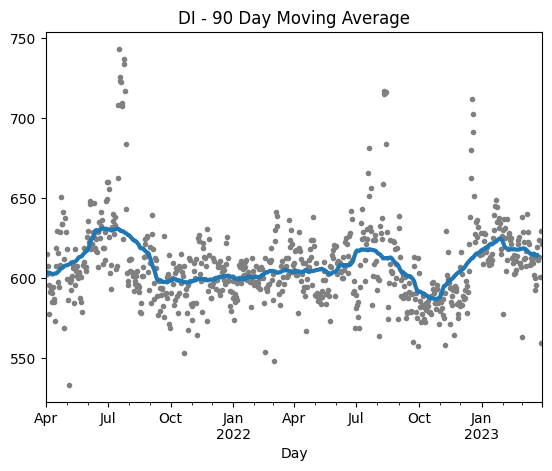

In [ ]:
moving_average = y_train.rolling(
    window=90,       # 365-day window
    center=True,      # puts the average at the centre of the window
    min_periods=44,  # choose about half the window size
).mean()              # compute the mean (could also do median, std, min, max, ...)

ax = y.plot(style=".", color="0.5")
moving_average.plot(
    ax=ax, linewidth=3, title="DI - 90 Day Moving Average", legend=False,
);


In [ ]:
moving_average

Day
2021-04-01    603.237358
2021-04-02    603.194662
2021-04-03    603.284237
2021-04-04    603.210058
2021-04-05    603.212108
                 ...    
2023-03-20    614.903517
2023-03-21    614.460140
2023-03-22    614.117782
2023-03-23    613.892769
2023-03-24    614.105785
Name: Flow (Ml/d), Length: 723, dtype: float64

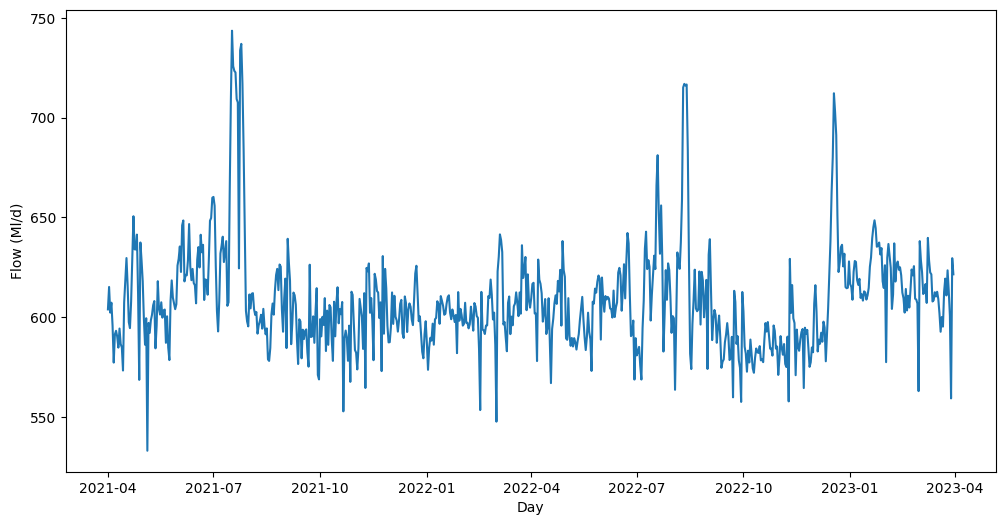

In [ ]:
y_detrended = y_train - moving_average

fig, ax = plt.subplots(figsize = (12,6))    
fig = sns.lineplot(y)

## Seasonality

In [ ]:
# test = pd.DataFrame(y_detrended.copy())
# # days within a week
# test["day"] = test.index.dayofweek  # the x-axis (freq)
# test["week"] = test.index.week  # the seasonal period (period)

# # days within a year
# test["dayofyear"] = test.index.dayofyear
# test["year"] = test.index.year

# fig, ax = plt.subplots(2, 1, figsize=(11, 6))
# seasonal_plot(test, y='Flow (Ml/d)', period="week", freq="day", ax=ax[0])
# seasonal_plot(test, y='Flow (Ml/d)', period="year", freq="dayofyear", ax=ax[1])

In [ ]:
# plot_periodogram(test['Flow (Ml/d)'])

periodogram suggests a high level of seasonality, weekly will be modelled with indicators. Most of seasonality drops off after a monthly, so we will use 16 fourier pairs.

In [ ]:
model = LinearRegression(fit_intercept=False)
model.fit(X_train, y_train)

y_pred = pd.Series(model.predict(X_train), index=X_train.index)
y_fore = pd.Series(model.predict(X_test), index=X_test.index)

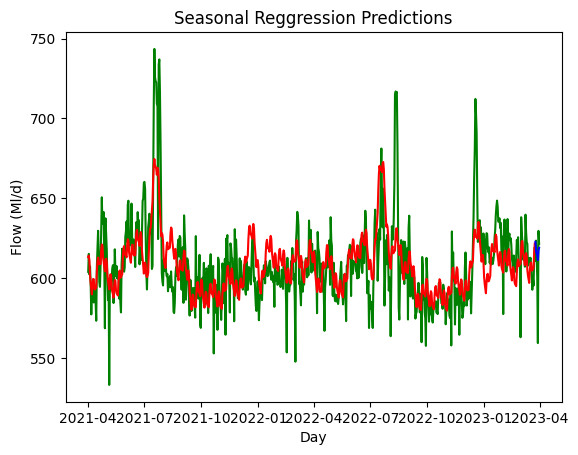

In [ ]:
sns.lineplot(y, color='g')
sns.lineplot(y_pred, color='r')
sns.lineplot(y_fore, color='b')
plt.title('Seasonal Reggression Predictions')
plt.show()

Average Error Over Entire Prediction:
Train RMSE: 20.24 Ml/d (3.33%)
Test RMSE: 21.44 Ml/d (3.52%)


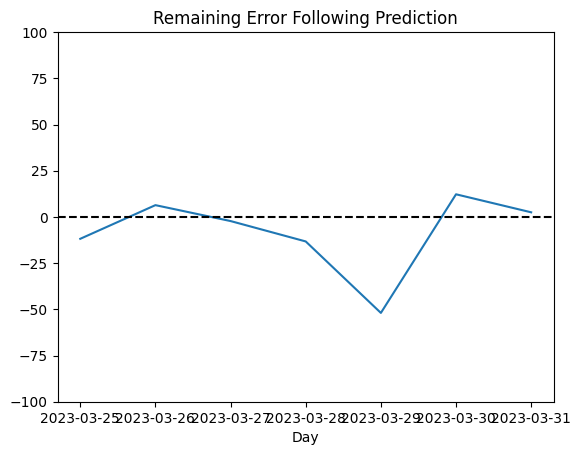

In [ ]:
y_deseasoned = y_train - y_pred
error = y_test - y_fore
train_rmse = mean_squared_error(y_train, y_pred, squared=False)
test_rmse = mean_squared_error(y_test, y_fore, squared=False)
print("Average Error Over Entire Prediction:")
print((f"Train RMSE: {train_rmse:.2f} Ml/d ({train_rmse/y_train.mean()*100:.2f}%)\n" f"Test RMSE: {test_rmse:.2f} Ml/d ({test_rmse/y_test.mean()*100:.2f}%)"))

error_graph = sns.lineplot(error)
error_graph.axhline(0, color='black', linestyle='dashed')
error_graph.set_ylim(-100,100)
plt.title("Remaining Error Following Prediction")
plt.show()

## Analyse correlations in lag plots

In [ ]:
# X = df.copy()
# y = X.pop('Flow (Ml/d)')
# plot_lags(y, lags=12, nrows=2);

In [ ]:
# from statsmodels.graphics.tsaplots import plot_pacf

# plot_pacf(y, lags=12);

It looks lke 2 lags of the target will be useful (these will be added in the step before training the XGBoost model

## XGBoost

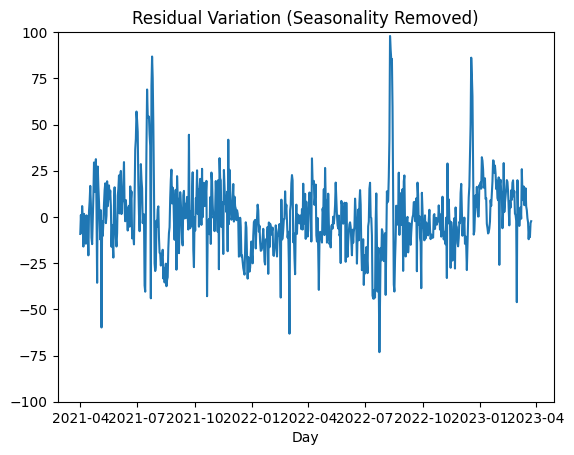

In [ ]:
y_residual = y_train - y_pred
fore_residual = y_test - y_fore

sns.lineplot(y_residual).set_ylim(-100,100)
plt.title("Residual Variation (Seasonality Removed)")
plt.show()

In [ ]:
# Make lags
X = X_xgb.copy()
# X0 = make_lags(y_train, lags=2)
# X0 = X0.fillna(0.0)
# X_train = pd.concat([X_train, X0], axis=1).fillna(0.0)

# X0 = make_lags(y_test, lags=2)
# X0 = X0.fillna(0.0)
# X_test = pd.concat([X_test, X0], axis=1).fillna(0.0)

In [ ]:
from xgboost import XGBRegressor

# Recreate the train/test split for X
X_train, X_test = X.loc[idx_train, :], X.loc[idx_test, :]

xgb = XGBRegressor(early_stopping_rounds=2)
xgb.fit(X_train, y_residual, eval_metric=['rmse'], eval_set=[(X_train, y_residual), (X_test, fore_residual)], verbose=True)

[0]	validation_0-rmse:17.89527	validation_1-rmse:20.80181
[1]	validation_0-rmse:16.31107	validation_1-rmse:20.72543
[2]	validation_0-rmse:15.16686	validation_1-rmse:20.60055
[3]	validation_0-rmse:14.37644	validation_1-rmse:20.28327
[4]	validation_0-rmse:13.67232	validation_1-rmse:19.20652
[5]	validation_0-rmse:13.23684	validation_1-rmse:19.06450
[6]	validation_0-rmse:12.83400	validation_1-rmse:18.59033
[7]	validation_0-rmse:12.45048	validation_1-rmse:18.57840
[8]	validation_0-rmse:12.09321	validation_1-rmse:18.28443
[9]	validation_0-rmse:11.53508	validation_1-rmse:18.28545
[10]	validation_0-rmse:11.29734	validation_1-rmse:17.67202
[11]	validation_0-rmse:10.83481	validation_1-rmse:17.67355
[12]	validation_0-rmse:10.50023	validation_1-rmse:17.53562
[13]	validation_0-rmse:10.21534	validation_1-rmse:17.53708


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=2,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

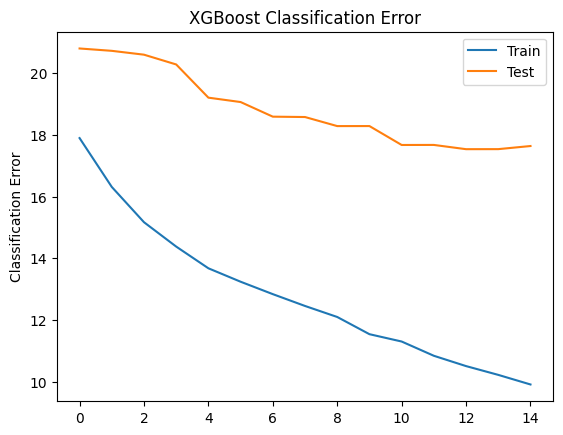

In [ ]:
# extract performance metrics from model
results = xgb.evals_result()
epochs = len(results['validation_0']['rmse'])
x_axis = range(0, epochs)

# # plot log loss
# fig, ax = plt.subplots()
# ax.plot(x_axis, results['validation_0']['logloss'], label='Train')
# ax.plot(x_axis, results['validation_1']['logloss'], label='Test')
# ax.legend()
# plt.ylabel('Log Loss')
# plt.title('XGBoost Log Loss')
# plt.show()

# plot classification error
fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['rmse'], label='Train')
ax.plot(x_axis, results['validation_1']['rmse'], label='Test')
ax.legend()
plt.ylabel('Classification Error')
plt.title('XGBoost Classification Error')
plt.show()

Average Error Over Entire Prediction:
Train RMSE: 10.50 Ml/d (1.73%)
Test RMSE: 17.54 Ml/d (2.88%)


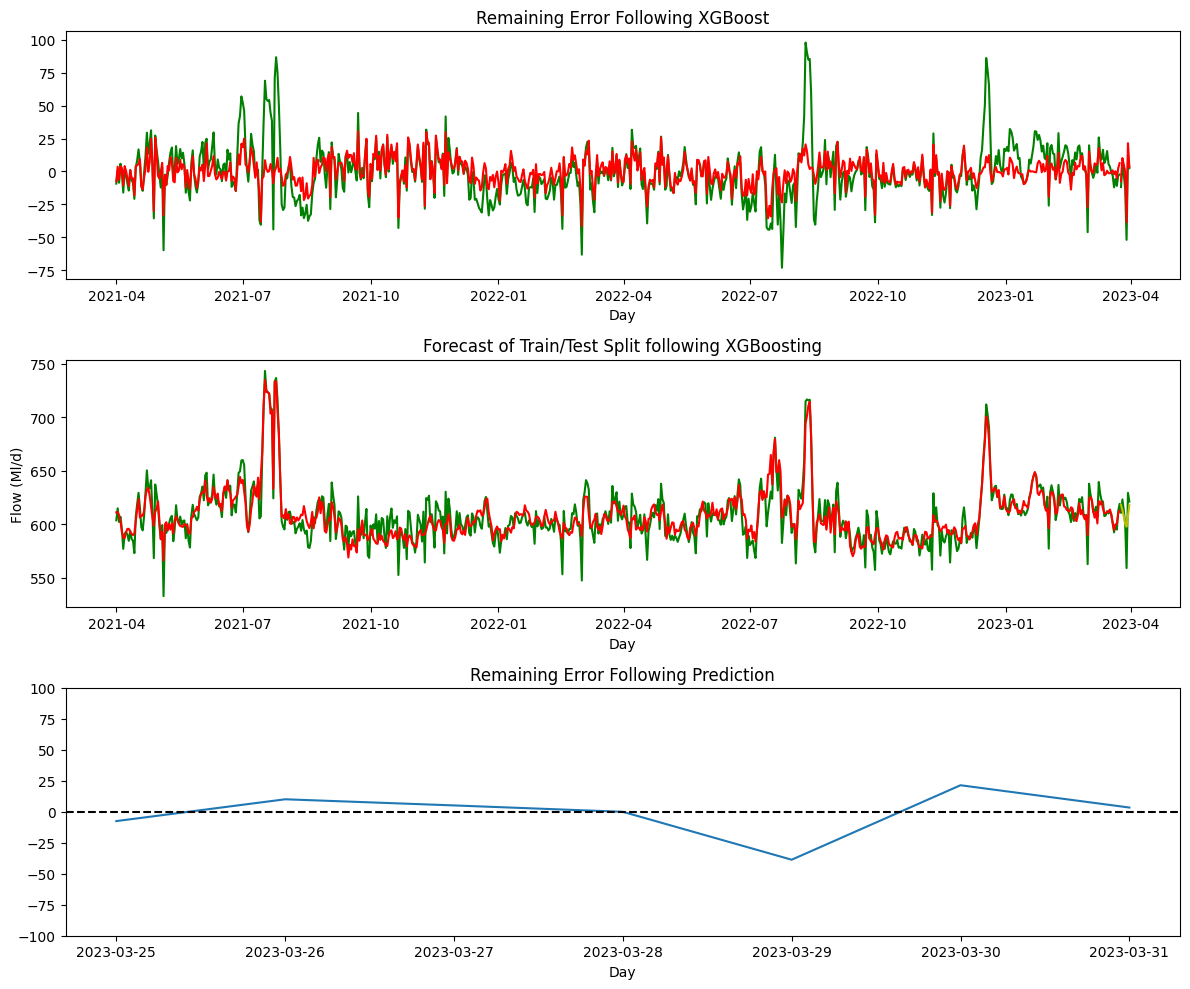

In [ ]:
error_pred_left = y_residual - xgb.predict(X_train)
y_pred_boosted = fore_residual - xgb.predict(X_test)

fig, ax = plt.subplots(nrows=3, ncols=1, figsize = (12,10))

sns.lineplot(y_residual, color='g', ax=ax[0])
sns.lineplot(fore_residual, color='g', ax=ax[0])
sns.lineplot(error_pred_left, color='r', ax=ax[0])
sns.lineplot(y_pred_boosted, color='r', ax=ax[0])
ax[0].set(title="Remaining Error Following XGBoost")

y_fit_boosted = xgb.predict(X_train) + y_pred
y_pred_boosted = xgb.predict(X_test) + y_fore

sns.lineplot(y, color='g', ax=ax[1])
sns.lineplot(y_fit_boosted, color='r', ax=ax[1])
sns.lineplot(y_pred_boosted, color='y', ax=ax[1])
ax[1].set(title="Forecast of Train/Test Split following XGBoosting")

from sklearn.metrics import mean_squared_error, accuracy_score
error = y - y_pred_boosted

train_rmse = mean_squared_error(y_train, y_fit_boosted, squared=False)
test_rmse = mean_squared_error(y_test, y_pred_boosted, squared=False)

print("Average Error Over Entire Prediction:")
print((f"Train RMSE: {train_rmse:.2f} Ml/d ({train_rmse/y_train.mean()*100:.2f}%)\n" f"Test RMSE: {test_rmse:.2f} Ml/d ({test_rmse/y_test.mean()*100:.2f}%)"))

error_graph = sns.lineplot(error, ax=ax[2])
error_graph.axhline(0, color='black', linestyle='dashed')
error_graph.set_ylim(-100,100)
ax[2].set(title="Remaining Error Following Prediction")

fig.tight_layout()
plt.show()

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

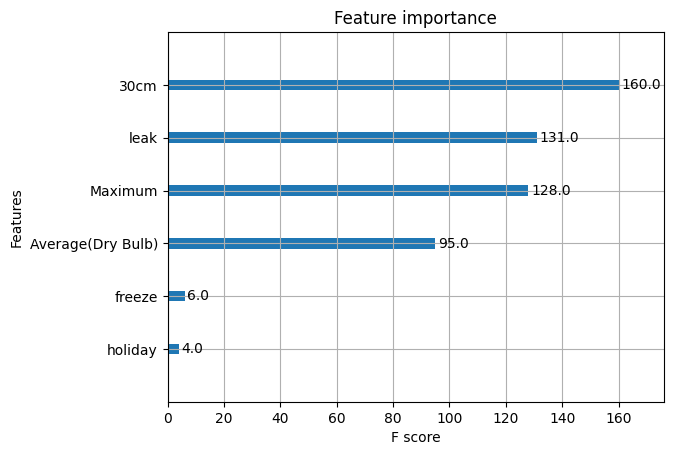

In [ ]:
# check feature importance
from xgboost import plot_importance
plot_importance(xgb)